# Parallelize HPO of XGBoost with Optuna and Dask

In [1]:
ACCOUNT = "dask-engineering"  # <-- Add your Coiled account here
FILEPATH="s3://coiled-datasets/prefect-dask/nyc-uber-lyft/feature_table.parquet"  # <-- Location of feature table
WORKER_INSTANCE_TYPE = "m6i.xlarge"  # <-- Dask worker instance size
CLUSTERS = {}    # Dict for collecting clusters for shutting down when done

In [2]:
from datetime import datetime
import threading
import joblib
from concurrent.futures import ThreadPoolExecutor

from distributed import Client, wait
import dask.dataframe as dd
import coiled

import dask
import numpy as np
import pandas as pd
import optuna
from dask_ml.metrics import mean_squared_error
import xgboost as xgb
from xgboost.dask import DaskDMatrix

import dask.dataframe as dd
import matplotlib.pyplot as plt

### Train Model

In [3]:
# Here we subset data for cross-validation
def make_cv_splits(df, num_folds):
    frac = [1 / num_folds]*num_folds
    splits = df.random_split(frac, shuffle=True)
    for i in range(num_folds):
        train = [splits[j] for j in range(num_folds) if j != i]
        test = splits[i]
        yield train, test

In [4]:
def train_model(trial_number, study_params, n_splits=5):
    thread_id = threading.get_ident()
    cluster_name = "xgb-nyc-taxi-gbh-" + str(thread_id)

    cluster = CLUSTERS.get(cluster_name, None)
    cluster = coiled.Cluster(
        worker_vm_types=[WORKER_INSTANCE_TYPE],
        scheduler_vm_types=["m6i.2xlarge"],
        package_sync=True,        # copy local packages,
        name=cluster_name,
        shutdown_on_close=False,  # reuse cluster across runs
        show_widget=False,
        n_workers=20,
        use_best_zone=True,
        account=ACCOUNT,
        backend_options={"region": "us-east-2", "spot": True},
        scheduler_options={"idle_timeout": "5 minutes"},
        )

    CLUSTERS[cluster_name] = cluster

    with Client(cluster) as client:
        with client.as_current():

            # Load and pre-process the DataFrame
            ddf = dd.read_parquet(FILEPATH)
            categorical_vars = ddf.select_dtypes(include="category").columns.tolist()
            ddf = ddf.categorize(columns=categorical_vars)
            float_cols = ddf.select_dtypes(include="float").columns.tolist()
            ddf[float_cols] = ddf[float_cols].astype(np.float32).persist()

            val_scores = []

            for train, test in make_cv_splits(ddf, n_splits):
                train = dd.concat(train)

                y_train = train['trip_time'].to_frame().persist()
                X_train = train.drop(columns=['trip_time']).persist()

                # Make the test data
                y_test = test['trip_time'].to_frame().persist()
                X_test = test.drop(columns='trip_time').persist()
                dtrain = DaskDMatrix(client, X_train, y_train, enable_categorical=True)

                model = xgb.dask.train(
                    client,
                    {'tree_method': 'hist', **study_params
                    },
                    dtrain,
                    num_boost_round=4,
                    evals=[(dtrain, "train")],
                )
                predictions = xgb.dask.predict(client, model, X_test)

                score = mean_squared_error(y_test.to_dask_array(lengths=True).reshape(-1,), 
                                           predictions.to_dask_array(lengths=True), squared=False,
                                          )
                val_scores.append(score)
            return np.mean(val_scores)

In [5]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 75, 125),
        'learning_rate': trial.suggest_float('learning_rate', 0.5, 0.7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        'max_leaves': trial.suggest_int('max_leaves', 0, 2),
        'max_cat_to_onehot': trial.suggest_int('max_cat_to_onehot', 1, 10),
    }
    rmse = train_model(
        trial_number=trial.number,
        study_params=params, 
    )
    return rmse

In [6]:
# Create a single study
start = datetime.now()
study = optuna.create_study(study_name="parallel-nyc-travel-time-model")    

with ThreadPoolExecutor(10) as executor:
    futures = [executor.submit(study.optimize, objective, n_trials=5) for _ in range(10)]
print(f"Total time:  {datetime.now() - start}")

[I 2023-01-16 06:21:17,391] A new study created in memory with name: parallel-nyc-travel-time-model
[I 2023-01-16 06:33:11,359] Trial 7 finished with value: 674.7250215758032 and parameters: {'n_estimators': 82, 'learning_rate': 0.533674597212377, 'colsample_bytree': 0.6387740231547269, 'colsample_bynode': 0.5564722607596619, 'colsample_bylevel': 0.6445900048149991, 'reg_lambda': 0.19716807285362348, 'max_depth': 3, 'max_leaves': 1, 'max_cat_to_onehot': 2}. Best is trial 7 with value: 674.7250215758032.
[I 2023-01-16 06:33:20,106] Trial 9 finished with value: 582.2835893961552 and parameters: {'n_estimators': 124, 'learning_rate': 0.5162423990653834, 'colsample_bytree': 0.9146667635492186, 'colsample_bynode': 0.5407675332903361, 'colsample_bylevel': 0.8897868807660241, 'reg_lambda': 0.9519093129477968, 'max_depth': 2, 'max_leaves': 2, 'max_cat_to_onehot': 1}. Best is trial 9 with value: 582.2835893961552.
[I 2023-01-16 06:33:57,003] Trial 3 finished with value: 499.2130770132856 and pa

Total time:  0:59:04.965889


In [7]:
# Tear down running clusters

for c in CLUSTERS.values():
    c.shutdown()

In [8]:
len(study.trials)

50

In [9]:
study.best_params

{'n_estimators': 112,
 'learning_rate': 0.5625784466810989,
 'colsample_bytree': 0.9893784257179837,
 'colsample_bynode': 0.6365637848355439,
 'colsample_bylevel': 0.9945763454512333,
 'reg_lambda': 0.7631702566711818,
 'max_depth': 6,
 'max_leaves': 0,
 'max_cat_to_onehot': 8}

In [10]:
study.best_value

338.48840812415267

In [11]:
# Uncomment this if you want to save the results of your study to examine later.

joblib.dump(study, "data/study_many_threads.pkl")

['data/study_many_threads.pkl']

/var/folders/b5/f_y899x168j7cs2m7szjld5c0000gn/T/ipykernel_85650/531804582.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


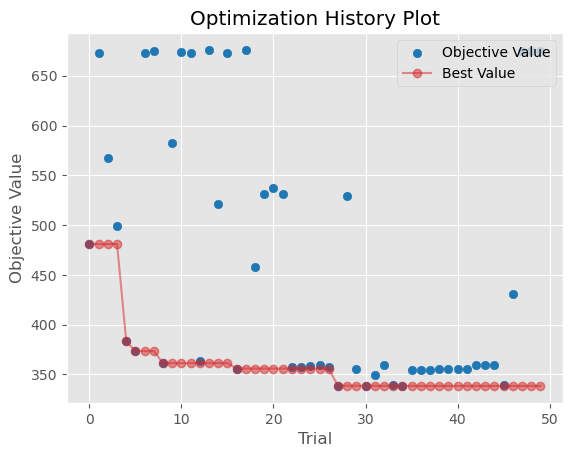

In [12]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
fig.legend(loc="upper right")
plt.savefig("data/optimization_history_study_2.png")

/var/folders/b5/f_y899x168j7cs2m7szjld5c0000gn/T/ipykernel_85650/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

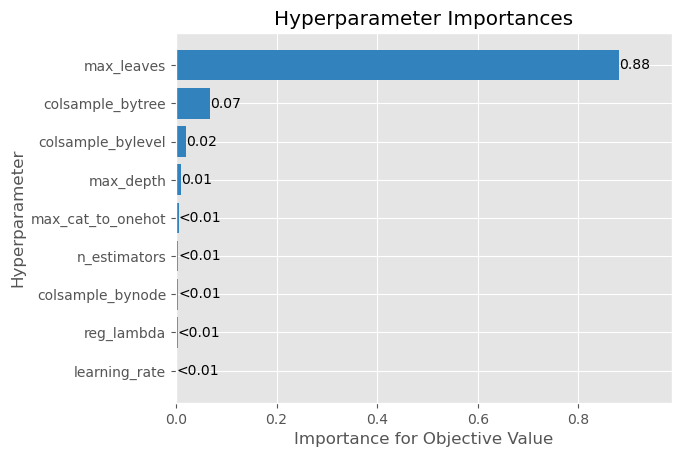

In [13]:
optuna.visualization.matplotlib.plot_param_importances(study)